# Algoritmi genetici: maximul unei funcții

Sîrbu Matei-Dan, _grupa 10LF383_

Să se implementeze un algoritm genetic care să calculeze maximul funcției:

$$\large f:[-20,20] \times [-5,5] \rightarrow (0, \infty); \  f(x,y) = \left| \frac{10x^2y - 5x^2 - 4y^2 - x^4 - 2y^4}{2} \right| + 1$$

Conform [WolframAlpha](https://www.wolframalpha.com/input/?i=maximum+of+f%28x%2Cy%29+%3D+abs%28%2810x%5E2y+-+5x%5E2+-+4y%5E2+-+x%5E4+-+2y%5E4%29%2F2%29+%2B+1%2C+-20%3C%3Dx%3C%3D20%2C+-5%3C%3Dy%3C%3D5), maximul este $(x,y) = (\pm 20, -5)$, cu $z = f(x, y) = 91676$.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML

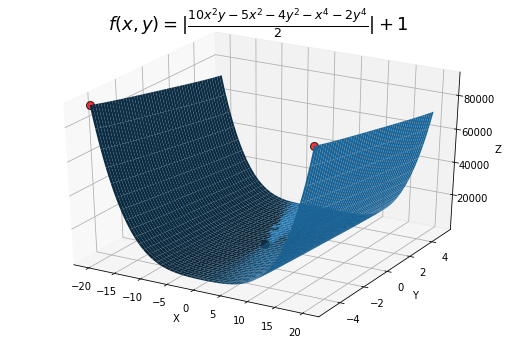

Maxima:
f( 20, -5) = 91676.0
f(-20, -5) = 91676.0


In [2]:
def function(x, y):
    return np.abs((10 * (x ** 2) * y - 5 * (x ** 2) - 4 * (y ** 2) - (x ** 4) - 2 * (y ** 4))/(2)) + 1

fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.set_title(r'$f(x,y) = \left| \frac{10x^2y - 5x^2 - 4y^2 - x^4 - 2y^4}{2} \right| + 1$', fontsize='18')
n = 10
x = np.linspace(-20, 20, 500)
y = np.linspace(-5, 5, 500)
X, Y = np.meshgrid(x, y)
z = np.array([function(x, y) for x, y in zip(np.ravel(X), np.ravel(Y))])
Z = z.reshape(X.shape)

ax.plot_surface(X, Y, Z)
ax.plot([20.], [-5.], [function(20, -5)], markerfacecolor='r', markeredgecolor='k', marker='o', markersize=8, alpha=0.8) # max
ax.plot([-20.], [-5.], [function(-20, -5)], markerfacecolor='r', markeredgecolor='k', marker='o', markersize=8, alpha=0.8) # max
ax.plot([0.], [0.], [function(0, 0)], markerfacecolor='k', markeredgecolor='k', marker='o', markersize=8, alpha=0.8) # min
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')

plt.show(); print('Maxima:'); print(f'f( 20, -5) = {function(20, -5)}'); print(f'f(-20, -5) = {function(20, -5)}')

## 1. Crearea populației inițiale de cromozomi

In [3]:
number_of_bits = 8 # k
population_size = 100 # n
number_of_generations = 700
mutation_probability = 0.01 # p_m
crossover_probability = 0.1
x_min, x_max = -20, 20 # x: a, b
y_min, y_max = -5, 5 # y: a, b

In [4]:
def decodeStrand(c, a, b, k):
    v = int(''.join(list(map(str, c))), 2)
    return a + v * (b - a)/(2**k - 1)

In [5]:
def decodePopulation(population, xa, ya, xb, yb, k):
    return [[decodeStrand(population[i][0], xa, xb, number_of_bits), decodeStrand(population[i][1], ya, yb, number_of_bits)] for i in range(0, population_size)]

In [6]:
def generatePopulation(n, k):
    return [np.random.randint(2, size=(2, k)) for i in range(n)]

In [7]:
population = generatePopulation(population_size, number_of_bits)
print(f'Chromosome 0:\n{population[0]}'); print(f'Chromosome 1:\n{population[1]}'); print(f'Chromosome 2:\n{population[2]}'); print(f'Chromosome 3:\n{population[3]}\n...')

Chromosome 0:
[[0 1 0 1 0 1 0 1]
 [1 1 1 0 1 0 1 1]]
Chromosome 1:
[[0 0 0 1 0 0 0 0]
 [1 0 1 1 0 0 0 0]]
Chromosome 2:
[[1 1 0 0 1 0 0 1]
 [1 1 1 1 0 1 0 1]]
Chromosome 3:
[[0 0 0 0 0 0 0 1]
 [1 0 0 0 1 0 1 1]]
...


In [8]:
decoded_population = decodePopulation(population, x_min, y_min, x_max, y_max, number_of_bits)
print(f'Chromosome 0:\n{decoded_population[0]}'); print(f'Chromosome 1:\n{decoded_population[1]}'); print(f'Chromosome 2:\n{decoded_population[2]}'); print(f'Chromosome 3:\n{decoded_population[3]}\n...')

Chromosome 0:
[-6.666666666666666, 4.215686274509803]
Chromosome 1:
[-17.490196078431374, 1.9019607843137258]
Chromosome 2:
[11.529411764705884, 4.607843137254902]
Chromosome 3:
[-19.84313725490196, 0.4509803921568629]
...


## 2. Evoluția populației

In [9]:
file = open('output.txt', 'w')


# contorizare generații și monitorizarea mediei populației
gen = 0
avg = []
avg.append(np.sum([function(decoded_population[i][0], decoded_population[i][1]) for i in range(population_size)])/population_size) # medie populație

while gen < number_of_generations:
    # 1. SELECȚIE
    y = [function(decoded_population[i][0], decoded_population[i][1]) for i in range(population_size)] # fcț. aplicată pe fiecare cromozom
    S = np.sum(y) # sumă funcții obiectiv
    p = y / S     # probabilitate de selecție
    q = [np.sum(p[:j+1]) for j in range(population_size)] # probabilitatea cumulativă de selecție
    
    u = np.random.uniform(0, 1, size=(population_size)) # numere aleatoare uniform distribuite din (0, 1]
    new_population = []
    
    for j in range(0, len(u)):
        for i in range(0, population_size):
            low = (0 if i == 0 else q[i-1])
            high = q[i]
            if low < u[j] and u[j] <= high:
                new_population.append(population[i])
                
    # 2. CROSSOVER
    parents = []
    u = np.random.uniform(0, 1, size=(population_size)) # numere aleatoare uniform distribuite din (0, 1]
    for i in range(population_size):
        if u[i] < crossover_probability:
            parents.append((population[i], i))
            
    for i in range(0, len(parents) // 2):
        p1_chromosomes, p1_idx = parents[2*i][0], parents[2*i][1]
        p2_chromosomes, p2_idx = parents[2*i + 1][0], parents[2*i + 1][1]
        t = np.random.randint(0, number_of_bits - 2)
        
        child1 = [np.concatenate((p1_chromosomes[0][:t+1],p2_chromosomes[0][t+1:])), np.concatenate((p1_chromosomes[1][:t+1],p2_chromosomes[1][t+1:]))]
        child2 = [np.concatenate((p1_chromosomes[0][t+1:],p2_chromosomes[0][:t+1])), np.concatenate((p1_chromosomes[1][t+1:],p2_chromosomes[1][:t+1]))]
           
        new_population[p1_idx] = child1
        new_population[p2_idx] = child2
    
    # 3. MUTAȚIE
    for chromosome in population:
        u = np.random.uniform(0, 1, size=(number_of_bits))
        for i in range(0, number_of_bits):
            if u[i] < mutation_probability:
                chromosome[0][i] = 0 if chromosome[0][i] == 1 else 1
                chromosome[1][i] = 0 if chromosome[1][i] == 1 else 1
    
    # actualizarea populației
    population = new_population
    decoded_population = decodePopulation(population, x_min, y_min, x_max, y_max, number_of_bits)
    
    y = [function(decoded_population[i][0], decoded_population[i][1]) for i in range(population_size)]
    S = np.sum(y)
    avg.append(S/population_size)
    
    # condiție de oprire: plafonarea mediei
    if (abs(avg[-1] - avg[-2]) < 1):
        break;
    
    # 4. EVALUAREA GENERAȚIEI
    fittest_chromosome_decoded = decoded_population[0]
    fittest_chromosome_z_value = function(fittest_chromosome_decoded[0], fittest_chromosome_decoded[1])
    for i in range(1, population_size):
        if (function(decoded_population[i][0], decoded_population[i][1]) > fittest_chromosome_z_value):
            fittest_chromosome_z_value = function(decoded_population[i][0], decoded_population[i][1])
            fittest_chromosome_decoded = decoded_population[i]
            
    print(f"Generația {gen}: Cel mai bun cromozom: x={round(fittest_chromosome_decoded[0], 4)}, y={round(fittest_chromosome_decoded[1], 4)}, z={fittest_chromosome_z_value}")
    
    file.write(f"#inceput date generatie {gen}\n")
    for chromosome in decoded_population:
        file.write(f"cromozom: x={chromosome[0]}, y={chromosome[1]}\n")
        file.write(f"valoare: {function(chromosome[0], chromosome[1])}\n")
    file.write(f"#sfarsit date generatie {gen}\n")
    
    gen = gen + 1
file.close()

Generația 0: Cel mai bun cromozom: x=-19.8431, y=0.451, z=77617.5246039253
Generația 1: Cel mai bun cromozom: x=-19.8431, y=0.451, z=77617.5246039253
Generația 2: Cel mai bun cromozom: x=-19.8431, y=0.451, z=77617.5246039253
Generația 3: Cel mai bun cromozom: x=20.0, y=-1.902, z=84825.24245768899
Generația 4: Cel mai bun cromozom: x=-19.8431, y=0.451, z=77617.5246039253
Generația 5: Cel mai bun cromozom: x=-19.8431, y=0.451, z=77617.5246039253
Generația 6: Cel mai bun cromozom: x=-19.6863, y=-4.098, z=84323.73087096748
Generația 7: Cel mai bun cromozom: x=-19.6863, y=-4.098, z=84323.73087096748
Generația 8: Cel mai bun cromozom: x=-19.6863, y=-4.098, z=84323.73087096748
Generația 9: Cel mai bun cromozom: x=-19.6863, y=-4.098, z=84323.73087096748
Generația 10: Cel mai bun cromozom: x=-19.8431, y=0.5686, z=77386.20999021316
Generația 11: Cel mai bun cromozom: x=-19.8431, y=0.5686, z=77386.20999021316
Generația 12: Cel mai bun cromozom: x=-19.8431, y=0.5686, z=77386.20999021316
Generația 